In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
import math

import random

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


## Important

as first step run the notebook `1. classification-dataset-creation.ipynb` to create the dataset.

In [2]:
dataset_path = '../data/dataset-dirigenti-split.pkl'

with open(dataset_path, 'rb') as f:
    train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = pickle.load(f)

### Transform it in a dataset

In [3]:
train_samples[:5]

array([ 'RESIDUI PERENTI BILANCIO 1997 - IMPEGNO E LIQUIDAZIONE ALL ORDINE PROVINCIALE DEI MEDICI-CHIRURGHI E DEGLI ODONTOIATRI DI FIRENZE PERL ATTUAZIONE DI INIZIATIVE CULTURALI E SCIENTIFICHE DI SUPPORTO AI CORSI DI FORMAZIONE SPECIFICA IN MEDICINA GENERALE.',
       'L.R. 72/94 " Danni causati da animali predatori o da eventi meteorici al patrimonio zootecnico" - Liquidazione indennizzi beneficiari Euro 34.988,28=.',
       'Eventi alluvionali novembre 2000 - Interventi urgenti connessi alla difesa idraulica - Erogazione al Comune di Montemurlo (PO) saldo finanziamento spettante per realizzazione intervento n. 301 compreso nel Piano regionale di cui all`allegato 2 della DGRT n. 104/2003.',
       'APPROVAZIONE SCHEMA DI CONVENZIONE TRA LA REGIONE TOSCANA E I SOGGETTI PRIVATI AMMESSI A CONTRIBUTO PER I PROGETTI-INTERVENTO IN MATERIA DI PAESAGGIO',
       'Contributo al Comune di Siena per l`organizzazione della Terza giornata del Contemporaneo in programma nel mese di ottobre 2007.']

In [4]:
train_labels[:5]

array(['01943', '01934',
       'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI',
       'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI',
       'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT'],
      dtype='<U54')

In [5]:
samples = np.concatenate([train_samples,val_samples, test_samples])
samples.shape

(138043,)

In [6]:
labels = np.concatenate([train_labels, val_labels, test_labels])
labels.shape

(138043,)

## Tokenize the Dataset

In [7]:
from keras.preprocessing.text import Tokenizer

In [8]:
num_words = 10000

In [9]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(samples)

In [10]:
train_sequences = tokenizer.texts_to_sequences(train_samples)
val_sequences = tokenizer.texts_to_sequences(val_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)

In [11]:
for s in train_sequences[:2]:
    print(s) 

[1120, 915, 418, 721, 14, 2, 18, 50, 2055, 530, 21, 1072, 2, 52, 1, 66, 179, 1, 691, 749, 2, 5399, 1, 512, 25, 723, 1, 129, 1100, 10, 558, 321]
[7, 6, 956, 88, 740, 2101, 45, 1187, 3733, 132, 45, 277, 4270, 13, 313, 1613, 18, 2539, 965, 221, 708, 7629, 298]


Convert labels to sequences

In [12]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [13]:
print(labels_to_index)
print(len(labels_to_index))

{'01934': 0, '01025': 1, 'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI': 2, 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 3, 'DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI': 4, 'DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI ': 5, '01946': 6, 'DIREZIONE GENERALE SVILUPPO ECONOMICO                 ': 7, "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 8, '01937': 9, 'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT': 10, 'DIREZIONE GENERALE BILANCIO E FINANZE                 ': 11, 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 12, 'POLITICHE AMBIENTALI, ENERGIA E CAMBIAMENTI CLIMATICI': 13, '01928': 14, 'D.G.  AVVOCATURA                                      ': 15, 'D.G. PRESIDENZA                                       ': 16, 'DIREZIONE ISTRUZIONE E FORMAZIONE': 17, 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 18, '01943': 19}
20


In [14]:
encoded_train_labels = [labels_to_index[l] for l in train_labels]
encoded_val_labels = [labels_to_index[l] for l in val_labels]
encoded_test_labels = [labels_to_index[l] for l in test_labels]

In [15]:
encoded_train_labels[:10]

[19, 0, 2, 2, 10, 15, 4, 17, 11, 8]

### Preparing Data

for data and labels

In [16]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [17]:
x_train = vectorize_sequences(train_sequences, num_words)
x_val = vectorize_sequences(val_sequences, num_words)
x_test = vectorize_sequences(test_sequences, num_words)

In [18]:
x_train[0:]

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [19]:
x_train.shape

(99390, 10000)

One hot encoding for the labels

In [20]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [21]:
y_train = to_one_hot(encoded_train_labels)
y_val = to_one_hot(encoded_val_labels)
y_test = to_one_hot(encoded_test_labels)

In [22]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

## Build the Models

apart the base model we add new methods with different kind of regularizers. In particular, we take into account:
- l2 that penalize the weights coefficient with a value proportional of their l1 and l2 norms. The general idea is that we prefer a simple model where the distribution of parameters values has less entropy.
- dropout where the idea is to reset randomly a percentage of the weights to zero in order to avoid that neurons start to memorize noise patterns.

In [23]:
def build_model(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [24]:
def build_model_l2(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(), input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [25]:
def build_model_dropout(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [28]:
model_base = build_model(256)

In [ ]:
history_base = model_base.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

In [31]:
model_l2 = build_model_l2(256)

In [32]:
history_l2 = model_l2.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 5s 54us/step - loss: 1.6216 - acc: 0.6632 - val_loss: 1.3138 - val_acc: 0.7438
Epoch 2/10
99390/99390 [==============================] - 5s 48us/step - loss: 1.2839 - acc: 0.7527 - val_loss: 1.2408 - val_acc: 0.7746
Epoch 3/10
99390/99390 [==============================] - 5s 49us/step - loss: 1.2227 - acc: 0.7772 - val_loss: 1.1981 - val_acc: 0.7853
Epoch 4/10
99390/99390 [==============================] - 5s 48us/step - loss: 1.1614 - acc: 0.7927 - val_loss: 1.1497 - val_acc: 0.7933
Epoch 5/10
99390/99390 [==============================] - 5s 49us/step - loss: 1.1121 - acc: 0.8050 - val_loss: 1.1338 - val_acc: 0.7952
Epoch 6/10
99390/99390 [==============================] - 5s 50us/step - loss: 1.0669 - acc: 0.8122 - val_loss: 1.0793 - val_acc: 0.8049
Epoch 7/10
99390/99390 [==============================] - 5s 49us/step - loss: 1.0270 - acc: 0.8185 - val_loss: 1.0689 - val_acc

In [33]:
model_dropout = build_model_dropout(256)

In [34]:
history_dropout = model_dropout.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 5s 50us/step - loss: 1.3007 - acc: 0.5892 - val_loss: 0.5782 - val_acc: 0.8056
Epoch 2/10
99390/99390 [==============================] - 5s 46us/step - loss: 0.6234 - acc: 0.7910 - val_loss: 0.4865 - val_acc: 0.8300
Epoch 3/10
99390/99390 [==============================] - 5s 47us/step - loss: 0.4775 - acc: 0.8391 - val_loss: 0.4516 - val_acc: 0.8435
Epoch 4/10
99390/99390 [==============================] - 5s 47us/step - loss: 0.3992 - acc: 0.8646 - val_loss: 0.4466 - val_acc: 0.8493
Epoch 5/10
99390/99390 [==============================] - 5s 47us/step - loss: 0.3438 - acc: 0.8837 - val_loss: 0.4380 - val_acc: 0.8525
Epoch 6/10
99390/99390 [==============================] - 5s 47us/step - loss: 0.3038 - acc: 0.8966 - val_loss: 0.4386 - val_acc: 0.8556
Epoch 7/10
99390/99390 [==============================] - 5s 47us/step - loss: 0.2731 - acc: 0.9067 - val_loss: 0.4518 - val_acc

### Printing The Loss

In [35]:
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
def chart_loss(history, name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss {}'.format(name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,2.2, step=0.2))
    plt.xticks(epochs)
    plt.legend()
    plt.show()

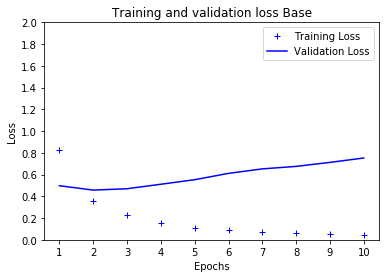

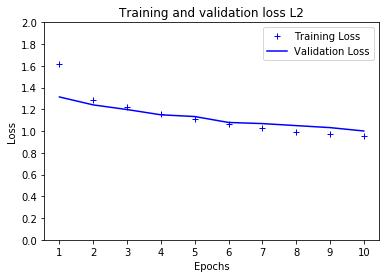

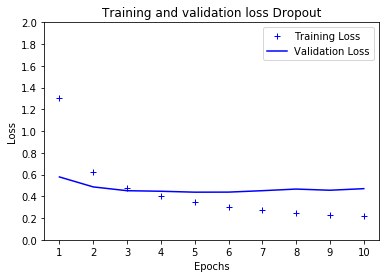

In [37]:
chart_loss(history_base, 'Base')
chart_loss(history_l2, 'L2')
chart_loss(history_dropout, 'Dropout')

From the charts we can see that: 
- the model with l2 regularization is able to avoid overfitting during the training. 
- the model that uses dropout (0.5) has a lower loss with respect to l2 while combatting overfitting

In [38]:
def chart_acc(history, name):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation acc {}'.format(name))
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.5,1.05, step=0.05))
    plt.xticks(epochs)
    plt.legend()
    plt.show()

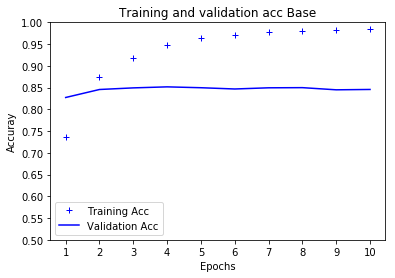

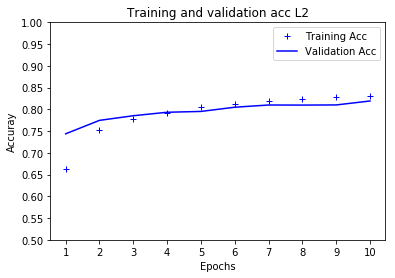

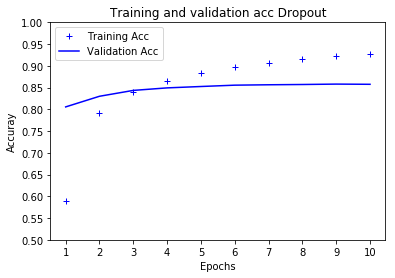

In [39]:
chart_acc(history_base, 'Base')
chart_acc(history_l2, 'L2')
chart_acc(history_dropout, 'Dropout')

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [40]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

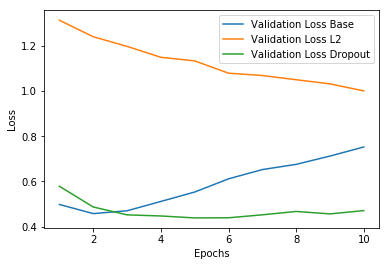

In [41]:
compare_loss({'Base': history_base, 'L2': history_l2, 'Dropout': history_dropout})

In [42]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

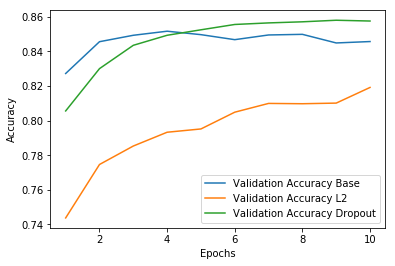

In [43]:
compare_accuracy({'Base': history_base, 'L2': history_l2, 'Dropout': history_dropout})

In [47]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1   

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch-1]

In [48]:
print('min loss for model base is {}'.format(min_loss(history_base)))
print('min loss for model L2 is {}'.format(min_loss(history_l2)))
print('min loss for model Dropout is {}'.format(min_loss(history_dropout)))

min loss for model base is 2
min loss for model L2 is 10
min loss for model Dropout is 5


In [50]:
print('best validation accuracy for model base {}'.format(
    accuracy(history_base, min_loss(history_base))))
print('best validation accuracy for model L2 {}'.format(
    accuracy(history_l2, min_loss(history_l2))))
print('best validation accuracy for model Dropout {}'.format(
    accuracy(history_dropout, min_loss(history_dropout))))

best validation accuracy for model base 0.84561752985889
best validation accuracy for model L2 0.819177834053309
best validation accuracy for model Dropout 0.8524990945525551


### Evaluate on the Test Set

- train the best model for the best epochs

In [51]:
import gc
gc.collect()

13779

In [56]:
model = build_model_dropout(256)

In [57]:
history = model.fit(x=np.concatenate([x_train, x_val]), y=np.concatenate([y_train, y_val]), epochs=5, batch_size=256)

Epoch 1/5
110434/110434 [==============================] - 5s 47us/step - loss: 1.2400 - acc: 0.6064
Epoch 2/5
110434/110434 [==============================] - 5s 43us/step - loss: 0.6031 - acc: 0.7991
Epoch 3/5
110434/110434 [==============================] - 5s 44us/step - loss: 0.4708 - acc: 0.8398
Epoch 4/5
110434/110434 [==============================] - 5s 45us/step - loss: 0.3976 - acc: 0.8646
Epoch 5/5
110434/110434 [==============================] - 5s 44us/step - loss: 0.3422 - acc: 0.8835


In [58]:
loss, acc = model.evaluate(x_test, y_test)

27609/27609 [==============================] - 1s 44us/step


In [59]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.4342908649430936
acc 0.8558803288890587


## Conclusion

As recap we can see that using regularization, in particular dropout, the accuracy grows from 0.841 to 0.855.